## LABORATORIO 6

##### Estudiante: Apaza Villca Cristofer Denilson
##### Dataset:Best Alzheimer's MRI Dataset 99% Accuracy
##### descripcion:  Este conjunto de datos es el resultado de una investigación pionera diseñada para resolver dos desafíos importantes en la investigación de la enfermedad de Alzheimer (EA): la escasez de datos y el grave desequilibrio de clases. Al aprovechar las GAN de Wasserstein con Penalización de Gradiente (WGAN-GP), generamos imágenes de resonancia magnética "axiales" DeepFake de alta fidelidad que coinciden con la calidad de los datos del mundo real
##### URL:https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy?select=Combined+Dataset

In [18]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import numpy as np

In [19]:
# Transformaciones para imágenes en blanco y negro de 128x128
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),  # Fuerza a 1 canal
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Rutas de los datos
train_dir = "C:/IA_PROJECTS/datasets/Best Alzheimer's MRI Dataset 99% Accuracy/train"
test_dir = "C:/IA_PROJECTS/datasets/Best Alzheimer's MRI Dataset 99% Accuracy/test"

# Cargar datasets
trainset = datasets.ImageFolder(root=train_dir, transform=transform)
testset = datasets.ImageFolder(root=test_dir, transform=transform)

# Mostrar la forma de una imagen para depuración
img, label = trainset[0]
print('Forma de la imagen de entrenamiento:', img.shape)  # Debe ser [1, 128, 128]

# Dataset personalizado para imágenes en blanco y negro
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, ix):
        img, label = self.dataset[ix]
        img = img.view(-1)  # Aplana la imagen (128*128)
        return img.cuda(), torch.tensor(label).long().cuda()

# Crear datasets para entrenamiento y validación
dataset = {
    'train': Dataset(trainset),
    'val': Dataset(testset)
}

# DataLoaders actualizados
dataloader = {
    'train': DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

# Verifica las clases
print("Clases:", trainset.classes)
print("Número de imágenes de entrenamiento:", len(trainset))
print("Número de imágenes de validación:", len(testset))

Forma de la imagen de entrenamiento: torch.Size([1, 128, 128])
Clases: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
Número de imágenes de entrenamiento: 10240
Número de imágenes de validación: 1279


In [20]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def build_model(D_in=128*128, H=100, D_out=4):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    ).cuda()

def fit(model, dataloader, optimizer, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1):
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [21]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
hist_sgd = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.44004 en epoch 1
Mejor modelo guardado con acc 0.48342 en epoch 4
Mejor modelo guardado con acc 0.48342 en epoch 4
Mejor modelo guardado con acc 0.59525 en epoch 6
Mejor modelo guardado con acc 0.59525 en epoch 6
Epoch 10/100 loss 0.52183 acc 0.78906 val_loss 0.86452 val_acc 0.56251
Epoch 10/100 loss 0.52183 acc 0.78906 val_loss 0.86452 val_acc 0.56251
Mejor modelo guardado con acc 0.65204 en epoch 13
Mejor modelo guardado con acc 0.65204 en epoch 13
Mejor modelo guardado con acc 0.71039 en epoch 17
Mejor modelo guardado con acc 0.71039 en epoch 17
Epoch 20/100 loss 0.35340 acc 0.85195 val_loss 0.62694 val_acc 0.69793
Epoch 20/100 loss 0.35340 acc 0.85195 val_loss 0.62694 val_acc 0.69793
Mejor modelo guardado con acc 0.72256 en epoch 24
Mejor modelo guardado con acc 0.72256 en epoch 24
Mejor modelo guardado con acc 0.73298 en epoch 26
Mejor modelo guardado con acc 0.73298 en epoch 26
Mejor modelo guardado con acc 0.73405 en epoch 28
Mejor modelo guardado

In [22]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_momentum = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.47483 en epoch 1
Mejor modelo guardado con acc 0.56822 en epoch 2
Mejor modelo guardado con acc 0.62370 en epoch 3
Mejor modelo guardado con acc 0.71099 en epoch 4
Mejor modelo guardado con acc 0.72516 en epoch 5
Mejor modelo guardado con acc 0.79309 en epoch 10
Epoch 10/100 loss 0.24458 acc 0.89883 val_loss 0.47301 val_acc 0.79309
Mejor modelo guardado con acc 0.82464 en epoch 15
Mejor modelo guardado con acc 0.84186 en epoch 17
Mejor modelo guardado con acc 0.87212 en epoch 20
Epoch 20/100 loss 0.13182 acc 0.95098 val_loss 0.30515 val_acc 0.87212
Mejor modelo guardado con acc 0.89024 en epoch 21
Mejor modelo guardado con acc 0.91278 en epoch 28
Epoch 30/100 loss 0.15830 acc 0.94355 val_loss 0.33269 val_acc 0.82558
Mejor modelo guardado con acc 0.92707 en epoch 31
Mejor modelo guardado con acc 0.93407 en epoch 34
Epoch 40/100 loss 0.17290 acc 0.93525 val_loss 0.45882 val_acc 0.80449
Mejor modelo guardado con acc 0.93658 en epoch 47
Epoch 50/100 loss 0.1

In [24]:
model = build_model()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
hist_rms = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.60324 en epoch 1
Mejor modelo guardado con acc 0.61010 en epoch 3
Mejor modelo guardado con acc 0.73440 en epoch 4
Mejor modelo guardado con acc 0.74956 en epoch 5
Mejor modelo guardado con acc 0.80703 en epoch 7
Mejor modelo guardado con acc 0.80705 en epoch 9
Epoch 10/100 loss 0.20386 acc 0.92412 val_loss 0.83530 val_acc 0.75341
Mejor modelo guardado con acc 0.83414 en epoch 11
Mejor modelo guardado con acc 0.87039 en epoch 12
Mejor modelo guardado con acc 0.91295 en epoch 13
Mejor modelo guardado con acc 0.91620 en epoch 18
Mejor modelo guardado con acc 0.94699 en epoch 20
Epoch 20/100 loss 0.13343 acc 0.96279 val_loss 0.14688 val_acc 0.94699
Mejor modelo guardado con acc 0.95362 en epoch 29
Epoch 30/100 loss 0.07195 acc 0.98506 val_loss 0.19232 val_acc 0.92786
Mejor modelo guardado con acc 0.95841 en epoch 32
Mejor modelo guardado con acc 0.96403 en epoch 39
Mejor modelo guardado con acc 0.96425 en epoch 40
Epoch 40/100 loss 0.11677 acc 0.98057 val_l

In [25]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
hist_adam = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.44906 en epoch 1
Mejor modelo guardado con acc 0.71358 en epoch 2
Mejor modelo guardado con acc 0.78415 en epoch 3
Mejor modelo guardado con acc 0.79806 en epoch 4
Mejor modelo guardado con acc 0.80539 en epoch 5
Mejor modelo guardado con acc 0.80918 en epoch 8
Mejor modelo guardado con acc 0.90628 en epoch 9
Mejor modelo guardado con acc 0.91124 en epoch 10
Epoch 10/100 loss 0.07186 acc 0.97334 val_loss 0.25111 val_acc 0.91124
Mejor modelo guardado con acc 0.91411 en epoch 15
Mejor modelo guardado con acc 0.92499 en epoch 20
Epoch 20/100 loss 0.07226 acc 0.97295 val_loss 0.20134 val_acc 0.92499
Mejor modelo guardado con acc 0.96549 en epoch 30
Epoch 30/100 loss 0.03164 acc 0.98848 val_loss 0.10305 val_acc 0.96549
Mejor modelo guardado con acc 0.97154 en epoch 33
Mejor modelo guardado con acc 0.97246 en epoch 34
Mejor modelo guardado con acc 0.97383 en epoch 38
Mejor modelo guardado con acc 0.97787 en epoch 40
Epoch 40/100 loss 0.00509 acc 0.99912 val_lo

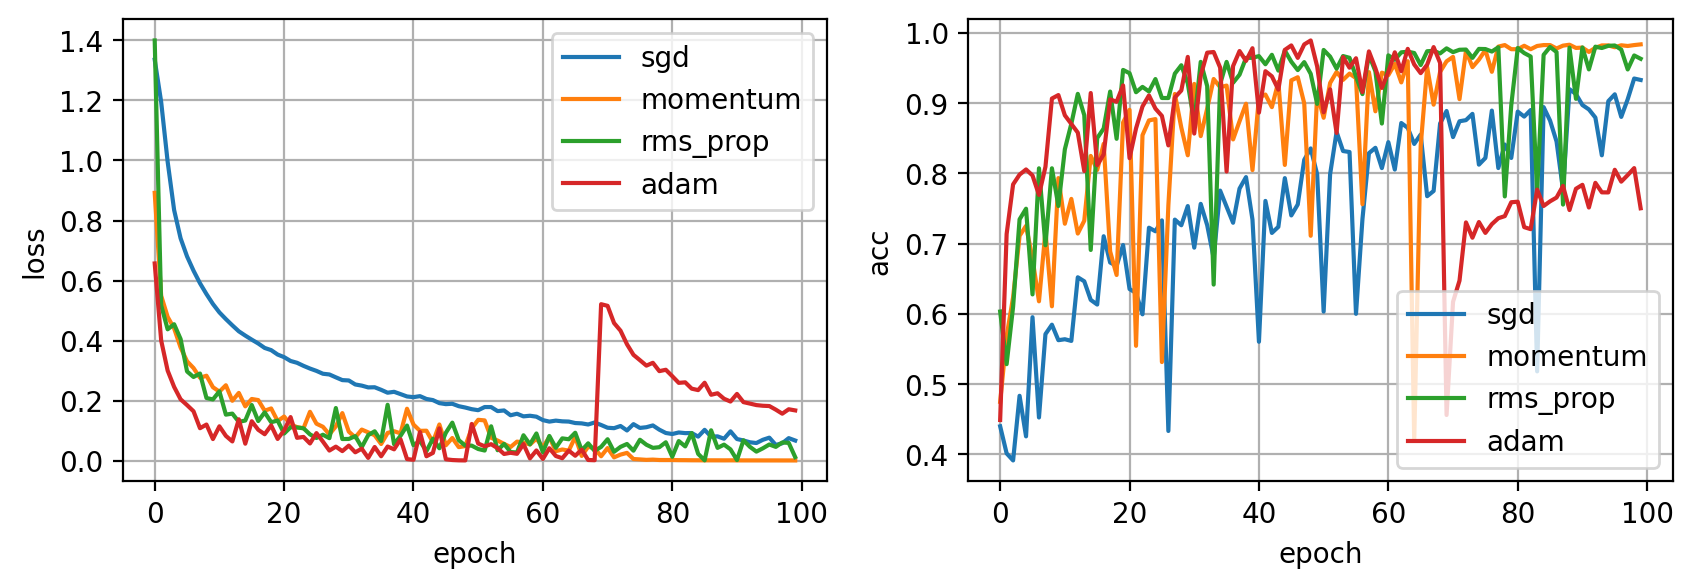

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_sgd['loss'], label="sgd")
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_rms['loss'], label="rms_prop")
ax.plot(hist_adam['loss'], label="adam")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(hist_sgd['val_acc'], label="sgd")
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_rms['val_acc'], label="rms_prop")
ax.plot(hist_adam['val_acc'], label="adam")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()